# Setup and Imports

In [1]:
!pip install rasterio albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 94.9 MB/s eta 0:00:00


In [2]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.5 MB/s eta 0:00:00


In [3]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2
import rasterio

In [4]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import albumentations as A

In [6]:
import segmentation_models_pytorch as smp

In [7]:
from google.colab import drive



---


# Reading the dataset

## Mount Google Drive

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


## Extract Zip File

In [9]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/Cellula Tech Intern Computer Vision/Task 3: Satellite Images Flooding Segmentation/satalite data-20250918T154859Z-1-001.zip'
extract_to = '/content/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

## Define Directory Paths

In [10]:
images_dir = os.path.join(extract_to, 'satalite data/data/images')
labels_dir = os.path.join(extract_to, 'satalite data/data/labels')

## **Function to Get Matched Image-Mask Pairs

In [11]:
def get_matched_pairs(images_dir, labels_dir):
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.tif')]
    pairs = []
    for img_file in image_files:
        stem = os.path.splitext(img_file)[0]
        mask_path = os.path.join(labels_dir, stem + '.png')
        if os.path.exists(mask_path):
            pairs.append((os.path.join(images_dir, img_file), mask_path))
    return pairs

In [12]:
pairs = get_matched_pairs(images_dir, labels_dir)
print(f"Found {len(pairs)} matched pairs.")

Found 306 matched pairs.


---

# Dataset Preprocessing

## Split into Train and Test Pairs

In [13]:
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2, random_state=42)

## Function to Load Multispectral Image

In [14]:
def load_image(path):
    with rasterio.open(path) as src:
        img = src.read()  # Shape: (12, 128, 128)
        img = img.astype(np.float32)
    return img

## Function to Load Binary Mask

In [15]:
def load_mask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 0).astype(np.float32)  # Binary 0/1
    return mask

## Compute Min-Max for Normalization (Per Channel)

In [16]:
def compute_min_max(train_pairs):
    mins = np.full(12, np.inf)
    maxs = np.full(12, -np.inf)
    for img_path, _ in train_pairs:
        img = load_image(img_path)
        channel_mins = np.min(img, axis=(1, 2))
        channel_maxs = np.max(img, axis=(1, 2))
        mins = np.minimum(mins, channel_mins)
        maxs = np.maximum(maxs, channel_maxs)
    return mins, maxs

In [17]:
mins, maxs = compute_min_max(train_pairs)

# Save mins and maxs for deployment
np.save('mins.npy', mins)
np.save('maxs.npy', maxs)

print("Mins and maxs computed and saved.")

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Mins and maxs computed and saved.


In [18]:
print("Min values:", mins)
print("Max values:", maxs)

Min values: [-1.393e+03 -1.110e+03 -6.330e+02 -6.270e+02 -4.120e+02 -3.350e+02
 -2.510e+02  6.400e+01 -9.999e+03  8.000e+00  1.000e+01  0.000e+00]
Max values: [ 6568.  9659. 11368. 12041. 15841. 15252. 14647.   255.  2784.  2762.
   100.   108.]




---



### E:

### Notes:

**I didn't use sklearn's MinMaxScaler primarily because the normalization needed here is a simple per-channel min-max scaling across the entire dataset, which can be efficiently implemented manually with NumPy operations without the overhead of reshaping the 3D image arrays (channels x height x width) into a 2D format that sklearn expects for fitting and transforming.**

**This keeps the code lightweight and avoids unnecessary library dependencies for such a basic arithmetic operation, while still achieving the exact same result as MinMaxScaler would provide if adapted for channel-wise use.**



---



## Function to Normalize Image (Min-Max Scaling)

In [19]:
def normalize_image(img, mins, maxs):
    for c in range(12):
        img[c] = (img[c] - mins[c]) / (maxs[c] - mins[c] + 1e-6)
    return img

## Loading, Normalizing and Visualization of Bands for a Sample Image

In [20]:
def visualize_bands(img_path, mins, maxs):
    img = load_image(img_path)
    img = normalize_image(img, mins, maxs)
    bands = [
        'Coastal aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2',
        'QA Band', 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurrence probability'
    ]
    fig, axs = plt.subplots(3, 4, figsize=(15, 10))
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(img[i], cmap='gray')
        ax.set_title(bands[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

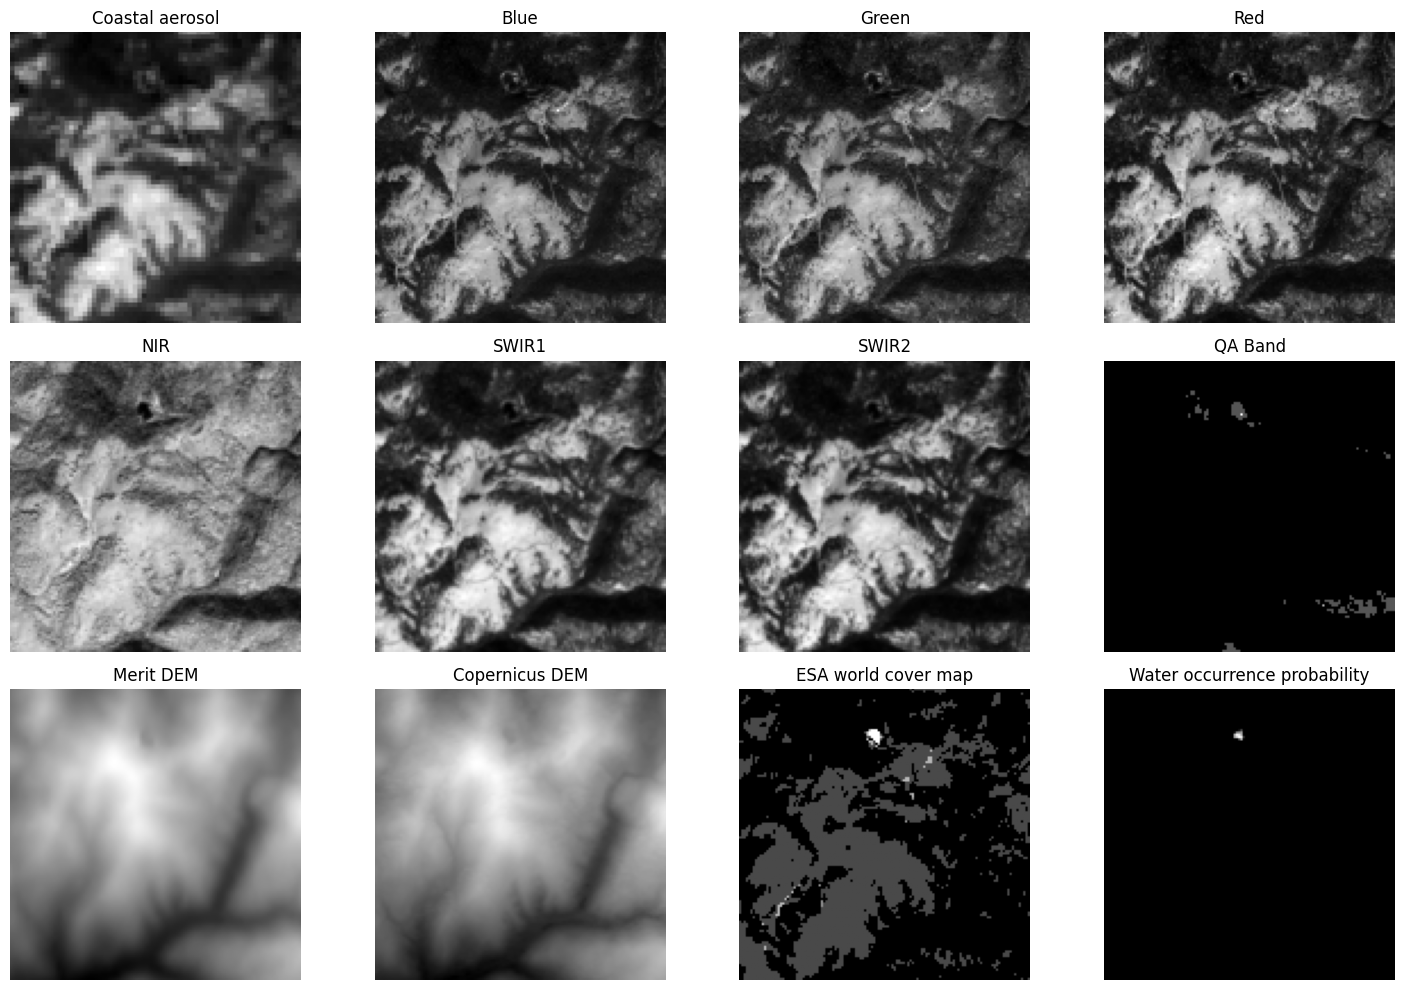

In [21]:
# Example: Visualize the first image
if train_pairs:
    visualize_bands(train_pairs[0][0], mins, maxs)

## Function to Compute Water Indices (Feature Engineering)

In [22]:
def compute_water_indices(img):
    # Channel indices based on diagram: 0: Coastal, 1: Blue, 2: Green, 3: Red, 4: NIR, 5: SWIR1, 6: SWIR2, ...
    green = img[2]
    nir = img[4]
    swir1 = img[5]
    swir2 = img[6]
    ndwi = (green - nir) / (green + nir + 1e-6)
    mndwi = (green - swir1) / (green + swir1 + 1e-6)
    awei = 4 * (green - swir1) - (0.25 * nir + 2.75 * swir2)
    indices = np.stack([ndwi, mndwi, awei], axis=0)
    img_with_indices = np.concatenate([img, indices], axis=0)  # Now (15, 128, 128)
    return img_with_indices

### Notes:

* (`NDWI`, `MNDWI`, `AWEI_SH`, `AWEI_NSH`, `NDVI`) are useful (two more than the ones I have above)

* I also included `awei` which isn't on the list above.

1. `NDWI` – **Normalized Difference Water Index**

* **Idea**: Water absorbs strongly in NIR, reflects in Green. So water → high positive NDWI, vegetation/soil → low or negative NDWI.

* **Benefit**: Helps model distinguish water from vegetation/soil where reflectance looks similar in RGB.

2. `MNDWI` - **Modified NDWI**

* **Idea**: Replaces NIR with SWIR, because SWIR is even more absorbed by water.

* **Benefit**: Suppresses built-up land and dark features (roads, shadows) that NDWI sometimes confuses as water.

3. `NDVI` - **Normalized Difference Vegetation Index**

* **Idea**: Vegetation reflects strongly in NIR, absorbs Red.

* **Benefit**: Separates vegetation from water and shadows. Even though it's not a water index, it gives the model “anti-water” info.

4. `AWEI_SH` - **Automated Water Extraction Index (Shadow version)**

* **Idea**: Targets shadowed regions, which NDWI/MNDWI confuse with water.

* **Benefit**: Reduces false positives from mountain/shadow areas.

5. `AWEI_NSH` - **Automated Water Extraction Index (Non-shadow version)**

* **Idea**: Optimized for non-shadow areas, where urban features confuse NDWI.

* **Benefit**: Helps in cities/built-up areas where water and asphalt look similar.

6. `AWEI` - **Automated Water Extraction Index**

This is what I have above in the code, it matches the AWEI_SH (shadow version).

from the original paper by Xu.

**AWEI shadow:**

idx["AWEI_SH"] = 4*(g - s1) - (0.25*n + 2.75*s2)

**AWEI non-shadow:**

idx["AWEI_NSH"] = g - (r + 2.5*n + 1.5*s1 + 0.25*s2)

## Function to Get Feature Importances Using Random Forest

In [23]:
def get_feature_importances(train_pairs, mins, maxs, sample_frac=0.01):
    data_list = []
    label_list = []
    feature_names = [
        'Coastal aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2',
        'QA Band', 'Merit DEM', 'Copernicus DEM', 'ESA world cover map', 'Water occurrence probability',
        'NDWI', 'MNDWI', 'AWEI'
    ]
    for img_path, mask_path in train_pairs:
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)
        img = compute_water_indices(img)  # (15, 128, 128)
        mask = load_mask(mask_path)
        flat_img = img.reshape(15, -1).T  # (16384, 15)
        flat_mask = mask.flatten()  # (16384,)
        num_samples = int(len(flat_mask) * sample_frac)
        indices = np.random.choice(len(flat_mask), num_samples, replace=False)
        data_list.append(flat_img[indices])
        label_list.append(flat_mask[indices])
    data = np.vstack(data_list)
    labels = np.hstack(label_list)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(data, labels)
    importances = clf.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    for idx in sorted_indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    # Return top features (e.g., all for now)
    return feature_names, importances

In [24]:
# Compute and print feature importances
feature_names, importances = get_feature_importances(train_pairs, mins, maxs)

NDWI: 0.1842
MNDWI: 0.1524
NIR: 0.1260
AWEI: 0.1063
SWIR1: 0.0648
Merit DEM: 0.0578
SWIR2: 0.0520
Copernicus DEM: 0.0518
Water occurrence probability: 0.0466
ESA world cover map: 0.0295
Red: 0.0291
Blue: 0.0289
Green: 0.0285
Coastal aerosol: 0.0277
QA Band: 0.0145


## Load Training and Testing Data

In [25]:
def load_dataset(pairs, mins, maxs, use_indices=True):
    images = []
    masks = []
    for img_path, mask_path in pairs:
        img = load_image(img_path)
        img = normalize_image(img, mins, maxs)   # normalization
        if use_indices:
            img = compute_water_indices(img)  # Use 15 channels if True
        mask = load_mask(mask_path)
        images.append(img)
        masks.append(mask)
    return np.stack(images), np.stack(masks)

In [26]:
# Load with indices (15 channels)
num_channels = 15
train_images, train_masks = load_dataset(train_pairs, mins, maxs, use_indices=True)
test_images, test_masks = load_dataset(test_pairs, mins, maxs, use_indices=True)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


## Function to Visualize Random Images in RGB Format

In [27]:
def visualize_random_rgb(images, num_samples=3):
    # Ensure images are in channel-first format (C, H, W) and select random indices
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))

    for idx, ax in zip(indices, axs):
        # Use bands 3 (Red), 2 (Green), 1 (Blue) for RGB approximation
        # Transpose to (H, W, C) and select RGB bands
        rgb = images[idx][[3, 2, 1]]  # Shape: (3, 128, 128)
        rgb = np.transpose(rgb, (1, 2, 0))  # Shape: (128, 128, 3)
        rgb = np.clip(rgb, 0, 1)  # Ensure values are in [0, 1] for display
        ax.imshow(rgb)
        ax.set_title(f'Image {idx} (RGB approx)')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

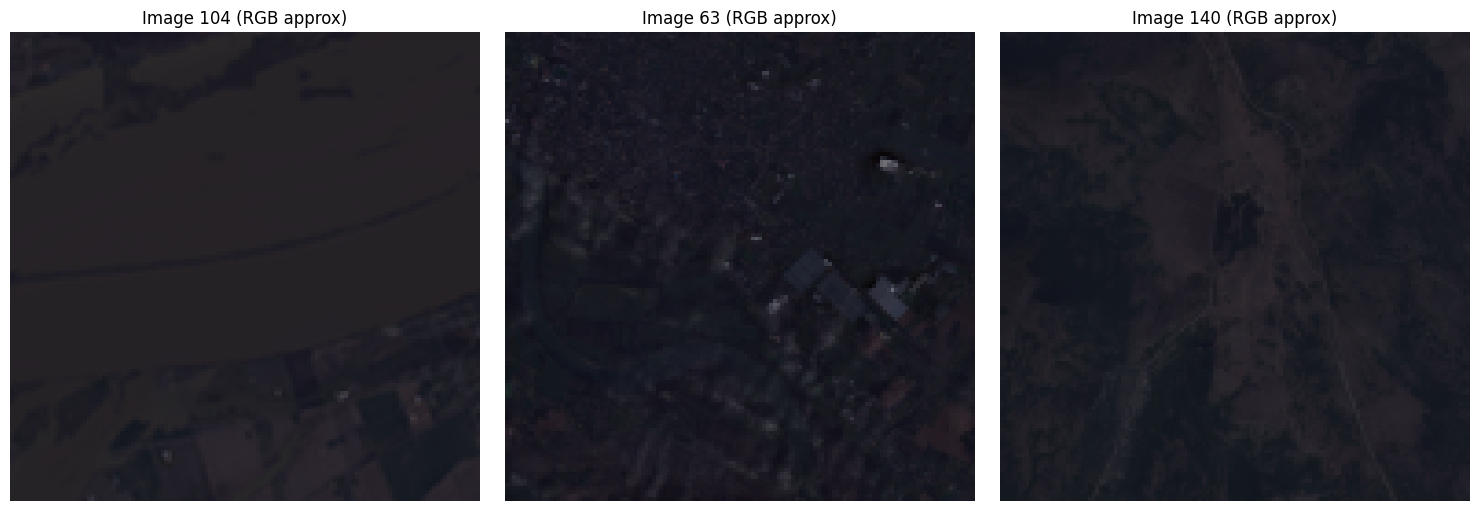

In [28]:
# Visualize random RGB images from training set before augmentation
visualize_random_rgb(train_images)

## Data Augmentation Using Albumentations

In [29]:
def augment_data(images, masks, num_augs=3):
    transform = A.Compose([
        #A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        # A.GaussNoise(p=0.3),

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5, brightness_limit=0.1, contrast_limit=0.1),

        # A.RandomFlip(p=0.5),
        # A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),   # mild noise
        # A.GaussNoise(std_range=(0.05, 0.1), mean_range=(0.0,0.0), p=0.2),   # mild noise
        A.GaussianBlur(blur_limit=2, p=0.2),          # small blur

        A.GridDistortion(distort_limit=0.05, p=0.2),  # small safe distortion
    ])
    aug_images = list(images)
    aug_masks = list(masks)
    for i in range(len(images)):
        for _ in range(num_augs):
            transposed_img = images[i].transpose(1, 2, 0)  # (128, 128, C)
            tr = transform(image=transposed_img, mask=masks[i])
            aug_img = tr['image'].transpose(2, 0, 1)  # Back to (C, 128, 128)
            aug_mask = tr['mask']
            aug_images.append(aug_img)
            aug_masks.append(aug_mask)
    return np.array(aug_images), np.array(aug_masks)

## Trying the Augmentations

In [30]:
def visualize_augmentations(images, masks, transform, num_samples=3):
    indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)

    for idx in indices:
        original_img = images[idx]
        original_mask = masks[idx]

        # Create RGB approximation of original image (assuming bands 3, 2, 1 exist)
        if original_img.shape[0] > 3:
            original_rgb = original_img[[3, 2, 1]]  # Select Red, Green, Blue bands
            original_rgb = (original_rgb - original_rgb.min()) / (original_rgb.max() - original_rgb.min() + 1e-6)
            original_rgb_display = np.transpose(original_rgb, (1, 2, 0))
        else:
            original_rgb_display = original_img[0, :, :] # Show first band if not enough bands

        # Apply augmentation
        # Albumentations expects HWC format, so transpose the image
        original_img_hwc = original_img.transpose(1, 2, 0)
        augmented = transform(image=original_img_hwc, mask=original_mask)
        augmented_img_hwc = augmented['image']
        augmented_mask = augmented['mask']

        # Transpose augmented image back to CHW for potential future processing (though not needed for display)
        # augmented_img_chw = augmented_img_hwc.transpose(2, 0, 1)

        # Create RGB approximation of augmented image (assuming bands 3, 2, 1 exist)
        # Need to transpose back to CHW briefly to select bands, then HWC for display
        if augmented_img_hwc.shape[-1] > 3:
            augmented_rgb = augmented_img_hwc[:, :, [3, 2, 1]] # Select Red, Green, Blue bands (HWC)
            augmented_rgb = (augmented_rgb - augmented_rgb.min()) / (augmented_rgb.max() - augmented_rgb.min() + 1e-6)
            augmented_rgb_display = augmented_rgb # Already in HWC
        else:
            augmented_rgb_display = augmented_img_hwc[:, :, 0] # Show first band if not enough bands


        fig, axs = plt.subplots(1, 4, figsize=(16, 5))

        # Original Image
        if original_rgb_display.ndim == 3:
            axs[0].imshow(original_rgb_display)
            axs[0].set_title('Original Image (RGB)')
        else:
             axs[0].imshow(original_rgb_display, cmap='gray')
             axs[0].set_title('Original Image (Band 1)')
        axs[0].axis('off')


        # Original Mask
        axs[1].imshow(original_mask, cmap='gray')
        axs[1].set_title('Original Mask')
        axs[1].axis('off')

        # Augmented Image
        if augmented_rgb_display.ndim == 3:
            axs[2].imshow(augmented_rgb_display)
            axs[2].set_title('Augmented Image (RGB)')
        else:
            axs[2].imshow(augmented_rgb_display, cmap='gray')
            axs[2].set_title('Augmented Image (Band 1)')

        axs[2].axis('off')

        # Augmented Mask
        axs[3].imshow(augmented_mask, cmap='gray')
        axs[3].set_title('Augmented Mask')
        axs[3].axis('off')


        plt.tight_layout()
        plt.show()

Visualizes random samples of original and augmented images (RGBapproximation) and their corresponding masks.

Args:
* images (np.ndarray): Array of original images (C, H, W).

* masks (np.ndarray): Array of original masks (H, W).

* transform (A.Compose): Albumentations transformation pipeline.

* num_samples (int): Number of random samples to visualize.

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


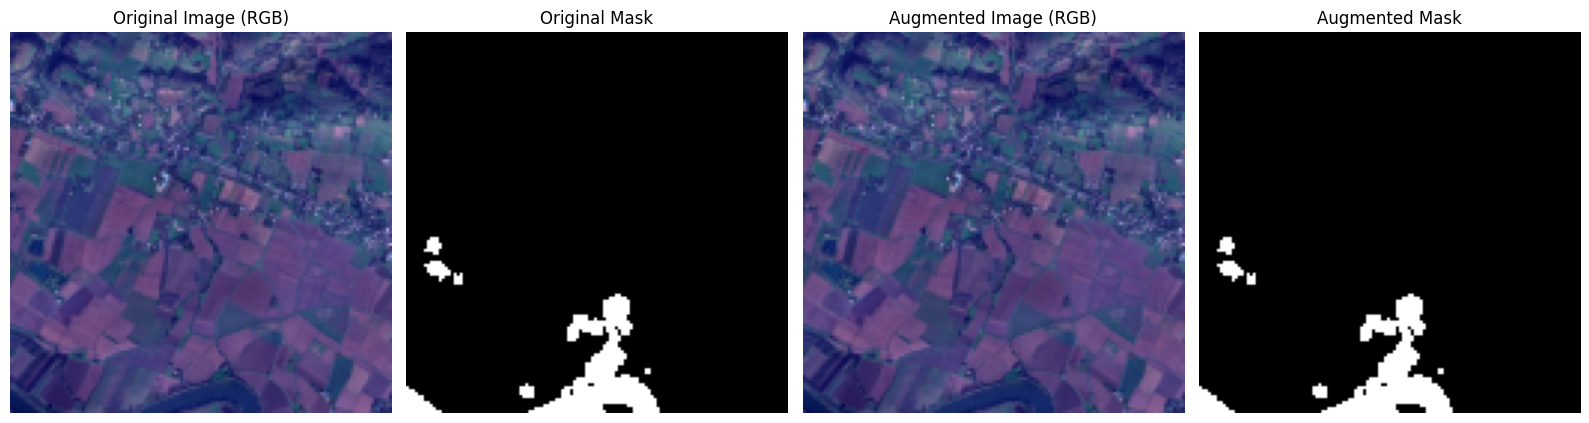

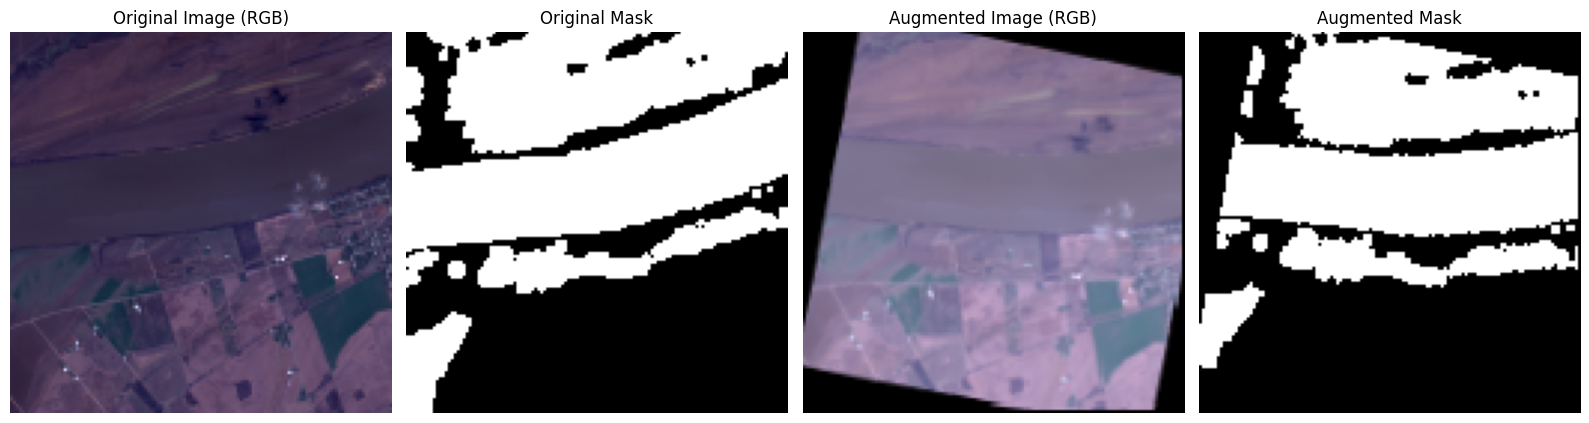

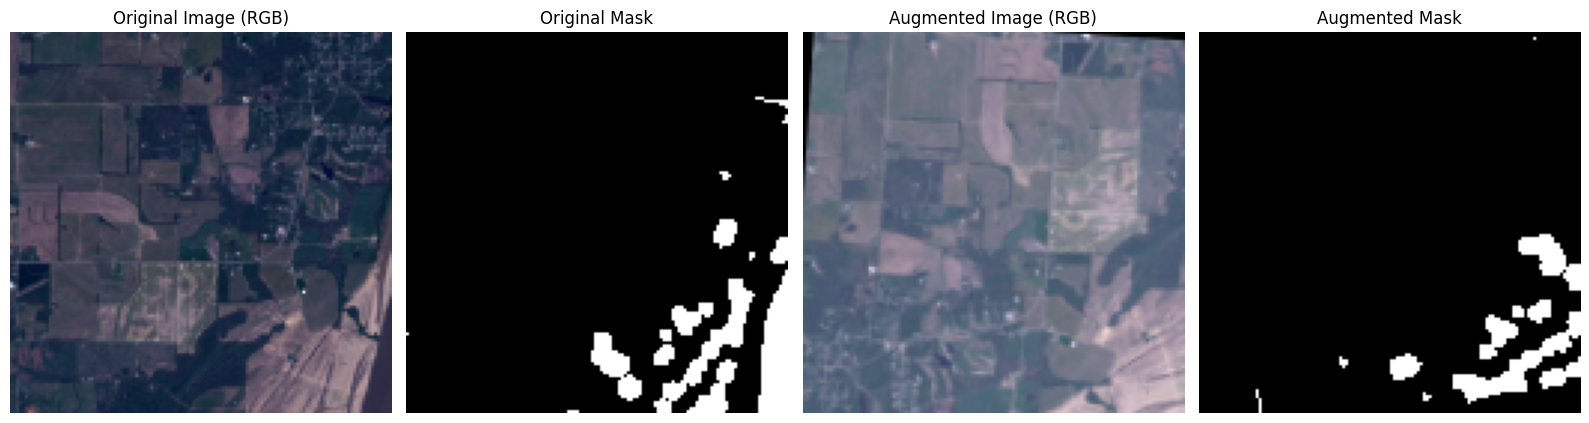

In [31]:
# Create an Albumentations transform instance
transform_for_viz = A.Compose([
        #A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
        # A.GaussNoise(p=0.3),

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.5, brightness_limit=0.1, contrast_limit=0.1),

        # A.RandomFlip(p=0.5),
        # A.GaussNoise(var_limit=(5.0, 15.0), p=0.2),   # mild noise
        # A.GaussNoise(std_range=(0.05, 0.1), mean_range=(0.0,0.0), p=0.2),   # mild noise
        A.GaussianBlur(blur_limit=2, p=0.2),          # small blur

        A.GridDistortion(distort_limit=0.05, p=0.2),  # small safe distortion
    ])

# Visualize 3 random samples from the training set with augmentations
visualize_augmentations(train_images[:50], train_masks[:50], transform_for_viz, num_samples=3) # Use a small subset for visualization efficiency

I used a separate transform instance (transform_for_viz) and the visualize_augmentations function just to give a preview of the augmentation effects without actually modifying the train_images and train_masks arrays yet.

In [32]:
train_images, train_masks = augment_data(train_images, train_masks)

## Prepare DataLoaders

In [33]:
train_dataset = TensorDataset(torch.from_numpy(train_images), torch.from_numpy(train_masks[..., np.newaxis]))  # Masks: (N, 128, 128, 1)
test_dataset = TensorDataset(torch.from_numpy(test_images), torch.from_numpy(test_masks[..., np.newaxis]))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



---


# Model

#